# Fractals

## Preamble

In [1]:
import numpy as np
from PIL import Image
from IPython.display import HTML
# install numba using conda, i.e.,  conda install numba
from numba import jit, njit

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
%run -i "rcParameters.py"

from ipywidgets import interact

plt.rcParams["font.family"]='Times New Roman'
plt.rcParams["mathtext.fontset"]='stix';

In [3]:
# set fontsize in markdown cells
from IPython.core.display import display, HTML, Latex
display(HTML("<style>.rendered_html { font-size: 16px; }</style>"))

## Mandelbrot set (version 1)

The _Mandelbrot set_ is a set of all complex numbers $c$ for which the sequence $z_{n+1}=z_n^2+c$ does not diverge to infinity when starting with $z_0=0$. 

In [4]:
@jit  # jit = just-in-time (compiler)
def make_mandelbrot(width, height, max_iterations):
    result = np.zeros((height, width))

    # for each pixel at (ix, iy)
    for iy in np.arange(height):
        for ix in np.arange(width):

            # start iteration at x0 in [-2, 1] and y0 in [-1, 1]
            x0 = ix*3.0/width - 2.0
            y0 = iy*2.0/height - 1.0

            x = 0.0
            y = 0.0
            # perform Mandelbrot set iterations
            for iteration in range(max_iterations):
                x_new = x*x - y*y + x0
                y = 2*x*y + y0
                x = x_new

                # if escaped
                if x*x + y*y > 4.0:
                    # color using pretty linear gradient
                    color = 1.0 - 0.01*(iteration - np.log2(np.log2(x*x + y*y)))
                    break
            else:
                # failed, set color to black
                color = 0.0

            result[iy, ix] = color

    return result

In [ ]:
# # without numba, i.e., without using @jit
# %time mandelbrot = make_mandelbrot(3000, 2000, 255)

# output: 
# CPU times: user 8min 19s, sys: 890 ms, total: 8min 20s
# Wall time: 8min 23s

In [5]:
# with numba
%time mandelbrot = make_mandelbrot(3000, 2000, 255)

CPU times: user 2.66 s, sys: 169 ms, total: 2.83 s
Wall time: 3.99 s


In [ ]:
# convert from float in [0, 1] to uint8 in [0, 255] for PIL
mandelbrot_ = np.clip(mandelbrot*255, 0, 255).astype(np.uint8)
mandelbrot_ = Image.fromarray(mandelbrot_)
mandelbrot_.save("FIGS/mandelbrot.png")
HTML('<image src="FIGS/mandelbrot.png" width=700>')

In [ ]:
y1=mandelbrot.min(); y2=mandelbrot.max()
norm = cm.colors.Normalize(0,y2)

fig, ax=plt.subplots(figsize=(10,10))
# ax.imshow(mandelbrot,cmap=cm.binary_r,norm=norm)
ax.imshow(mandelbrot,cmap=cm.brg,norm=norm)
ax.set_axis_off()
plt.show()

In [ ]:
# PIL built-in function
Image.effect_mandelbrot((512,512),(-2,-1.5,1,1.5),80)

## Mandelbrot set (version 2)

Use the `cplot` function in `mpmath` to plot the Mandelbrot set.

By default, the `fp` context is used for speed. The `mp` context could be used
to improve accuracy at extremely high zoom levels.

In [ ]:
import mpmath 
import cmath

ctx = mpmath.fp
# ctx = mpmath.mp

ITERATIONS = 50
POINTS = 100000
ESCAPE_RADIUS = 8

def mandelbrot(z):
    c = z
    for i in range(ITERATIONS):
        zprev = z
        z = z*z + c
        if abs(z) > ESCAPE_RADIUS:
            return ctx.exp(1j*(i + 1 - ctx.log(ctx.log(abs(z)))/ctx.log(2)))
    return 0

# Full plot
RE = [-2.5, 1.5]
IM = [-1.5, 1.5]
%time ctx.cplot(mandelbrot, RE, IM, points=POINTS, verbose=0)

# A pretty subplot
RE1 = [-0.96, -0.80]
IM1 = [-0.35, -0.2]
%time ctx.cplot(mandelbrot, RE1, IM1, points=POINTS, verbose=0)

### The _Julia set_ of $f(z)=z^2+c$, with $c\in {\mathbb C}$, is obtained by varying the initial value of $z$ 

In [ ]:
# Image width and height; parameters for the plot
im_width, im_height = 500, 500
c = complex(-0.1, 0.65) 
# c = complex(-0.8,.156) # also beautiful
zabs_max = 10
nit_max = 1000
xmin, xmax = -1.5, 1.5
xwidth = xmax - xmin
ymin, ymax = -1.5, 1.5
yheight = ymax - ymin

@jit(nopython=True)
def JuliaSet(im_width=im_width,im_height=im_height,
                    nit_max=nit_max,zabs_max=zabs_max):
    julia = np.zeros((im_width, im_height))
    for ix in range(im_width):
        for iy in range(im_height):
            nit = 0
            # Map pixel position to a point in the complex plane
            z = complex(ix / im_width * xwidth + xmin,
                        iy / im_height * yheight + ymin)
            # Do the iterations
            while abs(z) <= zabs_max and nit < nit_max:
                z = z**2 + c
                nit += 1
            shade = 1-np.sqrt(nit / nit_max)
            ratio = nit / nit_max
            julia[ix,iy] = ratio
    return julia
%time julia = JuliaSet()

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(julia, interpolation='nearest', cmap=cm.ocean_r)
ax.axis('equal')

# Set the tick labels to the coordinates of z0 in the complex plane
xtick_labels = np.linspace(xmin, xmax, int(xwidth // 0.5))
ax.set_xticks([(x-xmin) / xwidth * im_width for x in xtick_labels])
ax.set_xticklabels(['{:.1f}'.format(xtick) for xtick in xtick_labels])
ytick_labels = np.linspace(ymin, ymax, int(yheight // 0.5))
ax.set_yticks([(y-ymin) / yheight * im_height for y in ytick_labels])
ax.set_yticklabels(['{:.1f}'.format(ytick) for ytick in ytick_labels])

# ax.set_axis_off()
ax.set_title(r"The Julia Set for $f(z)=z^2+{}$".format(c),fontsize=18)
ax.set_xlabel('$Re(z)$')
ax.set_ylabel('$Im(z)$')
plt.show()
#plt.savefig('JuliaSet.png')

## Koch curve 

In [6]:
# R(x) = rotation matrix (operator) by angle x [in rad]
R = lambda x: np.array([[np.cos(x),-np.sin(x)],[np.sin(x),np.cos(x)]])

# recursive algorithm to draw a n-th order Koch curve 
#  starting from A=(x,y) and ending at B=(x+d.nx,y+d.ny)
def koch(nx,ny,d,n):
    global x,y
    if n == 0:
        x = np.append(x,x[-1]+d*nx)        
        y = np.append(y,y[-1]+d*ny)
    else:
        for ang in [np.pi/3,-2*np.pi/3,np.pi/3,0]:
            koch(nx,ny,d/3,n-1)
            [nx,ny] = np.dot(R(ang),[nx,ny])

In [7]:
@interact(n=(0,6,1))
def update(n=0):
    global x,y
    x=[0]; y=[0];
    koch(1,0,1,n)
    
    fig, ax=plt.subplots(figsize=(12,12))
    ax.plot(x,y,'r-',lw=0.5)
    ax.set_aspect('equal')
    ax.set_ylim(-0.05,0.3)
    ax.set_axis_off()
    plt.show()

interactive(children=(IntSlider(value=0, description='n', max=6), Output()), _dom_classes=('widget-interact',)…

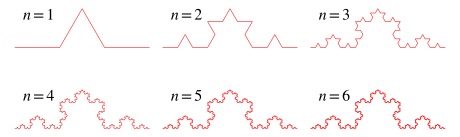

In [8]:
# plot Koch curves for n=1,...,6
global x,y

fig, ax=plt.subplots(2,3,figsize=(8,3),sharex=True,sharey=True,gridspec_kw={'wspace':0.0,'hspace':0.0})
for n in range(6):
    x=[0]; y=[0];
    koch(1,0,1,n+1)
    ax[n//3,n%3].plot(x,y,'r-',lw=0.5)
    ax[n//3,n%3].set_aspect('equal')
    ax[n//3,n%3].set_ylim(-0.01,0.3)
    ax[n//3,n%3].set_axis_off()
    ax[n//3,n%3].text(0.1,0.7,'$n={}$'.format(n+1),fontsize=16,transform=ax[n//3,n%3].transAxes)
# fig.savefig('FIGS/Koch_curve.pdf')
plt.show()

### Koch snowflake

In [ ]:
# construct n-th order Koch curves along the sides of an equilateral triangle = Koch snowflake
nx0=[0.5,0.5,-1]
ny0=[np.sin(np.pi/3),-np.sin(np.pi/3),0]
x0 =[0,0.5,1]
y0 =[0,np.sin(np.pi/3),0]

@interact(n=(0,6,1))
def update(n=0):
    global x,y
    fig, ax=plt.subplots(figsize=(10,10))
    for x1,y1,nx,ny in zip(x0,y0,nx0,ny0):
        x=[x1]; y=[y1]
        koch(nx,ny,1,n)
        ax.plot(x,y,'r-',lw=0.5)
    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.set_ylim(-0.3,0.9)
    plt.show()

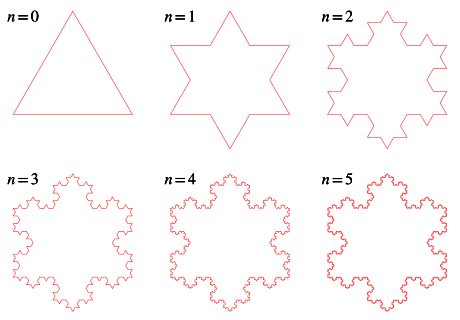

In [69]:
# plot Koch snowflakes for n=1,...,6
nx0=[0.5,0.5,-1]
ny0=[np.sin(np.pi/3),-np.sin(np.pi/3),0]
x0 =[0,0.5,1]
y0 =[0,np.sin(np.pi/3),0]

global x,y
fig, ax=plt.subplots(2,3,figsize=(8,6),sharex=True,sharey=True,gridspec_kw={'wspace':0.2,'hspace':0.0})
for n in range(6):
    for x1,y1,nx,ny in zip(x0,y0,nx0,ny0):
        x=[x1]; y=[y1]
        koch(nx,ny,1,n)
        ax[n//3,n%3].plot(x,y,'r-',lw=0.5)
        ax[n//3,n%3].text(0.,0.9,'$n={}$'.format(n),fontsize=16,transform=ax[n//3,n%3].transAxes)
    ax[n//3,n%3].set_aspect('equal')
    ax[n//3,n%3].set_axis_off()
    ax[n//3,n%3].set_ylim(-0.3,0.9)
# fig.savefig('FIGS/Koch_snowflakes.pdf')
plt.show()